In [8]:
# IMPORTS
import os
import tensorflow as tf
import time
from collections import deque

from environment.Config import ConfigTimeSeries
from environment.BaseEnvironment import TimeSeriesEnvironment
from resources.Utils import load_object, store_object
import numpy as np
import random
import os

from resources import Utils as utils
from resources.Plots import plot_actions
from tensorflow import keras


# custom modules
from agents.NeuralNetwork import NeuralNetwork

NOWHERE NEAR TO WORKING


In [9]:
LAMBDA = 0.9

We need to modify our agent to use a multi step target update, so our traces
are able to differentiate between sudden changes in the value function

In [10]:
# Global Variables
BATCH_SIZE = 512


class DDQNWAgent:
    def __init__(self, actions, alpha, gamma, epsilon, epsilon_min, epsilon_decay):
        self.nA = actions
        self.memory = MemoryBuffer(max=50000)
        self.batch_size = BATCH_SIZE
        self.alpha = alpha
        self.gamma = gamma
        # Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        # fitting param
        self.epoch_count = 10
        self.model = NeuralNetwork(input_dim=25, input_neurons=6, hidden_neurons=128).keras_model
        self.model_target = NeuralNetwork(input_dim=25, input_neurons=6, hidden_neurons=128) .keras_model # Second (target) neural network
        self.update_target_from_model()  # Update weights
        self.hist = None
        self.loss = []

    def action(self, state):
        # returns a random action or greedy plus a boolean if the action was choosen greedy or random
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.nA)  # Explore
        if self.epsilon == 0:
            action_vals = self.model_target.predict(np.array(state).reshape(1,
                                                                            25))
            #print("Pred 0\n{}".format(action_vals[0][0]))
            #print("Pred 1\n{}".format(action_vals[0][1]))
        else:
            action_vals = self.model.predict(np.array(state).reshape(1,
                                                                     25))  # Exploit: Use the NN to predict the correct action from this state
        return np.argmax(action_vals)

    def experience_replay(self, batch_size, lstm, step_size=5):
        # get a sample from the memory buffer
        minibatch = self.memory.get_exp(batch_size)

        # create default input arrays for the fitting of the model
        x = []
        y = []

        st_predict, nst_predict, nst_predict_target = self.predict_on_batch(minibatch)

        index = 0
        step = 1
        reward_ = 0
        for state, action, reward, nstate, done in minibatch:
            if step <= step_size:
#                 print("-------Trace Step {}--------".format(step))
#                 print("S1: {}".format(state))
#                 print("A: {}".format(action))
#                 print("R: {}".format(reward))
#                 print("S2: {}".format(nstate))
#                 print("D: {}".format(done))
#                 print("Lambda: {}".format(LAMBDA**step))
                reward_ = reward_ + reward * (LAMBDA**step)
#                 print("R_: {}".format(reward_))
                x.append(state)
                # Predict from state
                nst_action_predict_target = nst_predict_target[index]
                nst_action_predict_model = nst_predict[index]
                if done == True:  # Terminal: Just assign reward
                    target = reward_
                else:  # Non terminal
                    target = reward_ + self.gamma * nst_action_predict_target[
                        np.argmax(nst_action_predict_model)]  # Using Q to get T is Double DQN
                target_f = st_predict[index]
                target_f[action] = target
                y.append(target_f)
                index += 1
                step += 1
            else:
#                 print("Resetting Trace")
                step = 1
                reward_ = 0
        # Reshape for Keras Fit
        x_reshape = np.array(x)
        y_reshape = np.array(y)
        self.hist = self.model.fit(x_reshape, y_reshape, epochs=self.epoch_count, verbose=0)

    def predict_on_batch(self, batch):
        # Convert to numpy for speed by vectorization
        st = np.array(list(list(zip(*batch))[0]))
        nst = np.array(list(list(zip(*batch))[3]))

        # predict on the batches with the model as well as the target values
        st_predict = self.model.predict(st)
        nst_predict = self.model.predict(nst)
        nst_predict_target = self.model_target.predict(nst)

        return st_predict, nst_predict, nst_predict_target

    def update_target_from_model(self):
        # Update the target model from the base model
        self.model_target.set_weights(self.model.get_weights())

    def anneal_eps(self):
        self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)



We need to modify the Memory Replay, so we can store
every transition inside our environment at least once

In [11]:
class MemoryBuffer:
    def __init__(self, max):
        self.memory = deque([], maxlen=max)
        self.memory_copy = deque([], maxlen=max)

    def store(self, state, action, reward, nstate, done):
        # Store the experience in memory
        self.memory.append((state, action, reward, nstate, done))

    def init_memory(self, env, step_size=25):
        # time measurement for memory initialization
        init_time = time.time()
        # resetting environment once
        env.reset()
        # try to load memory from local file
        if not os.path.isfile("memory.obj"):
            print("Test")
            #self.memory = load_object("memory.obj")
        # try to init memory by taking random steps in our environment until the deque is full
        else:
            # init trajectory step
            step = 1
            reward_ = 0
            action_type = 0
            while True:
                if action_type % 2 == 0:
                    if step <= step_size:
                        # break if memory is full
                        if len(self.memory) >= self.memory.maxlen:
                            break
                        # check if we need to reset env and still fill our memory
                        if env.is_done(env.timeseries_cursor):
                            env.reset()
                            action_type = 1
#                             print("---------NEW STRATEGY INIT-------\n\n\n")
                        # get random action
                        action = random.randrange(env.action_space_n)
                        # take step in env and append
                        state, action, reward, nstate, done = env.step(action)
                        reward_ = reward_ + reward * (LAMBDA**step)
                        step += 1
                        # store our memory in class
                        self.store(state, action, reward_, nstate, done)
#                         print("TIMESTAMP: \t{}".format(env.timeseries_cursor))
#                         print(state[-1], action, reward_, nstate[-1], done)
                    else:
#                         print("Starting new trajectory normal")
                        step = 1
                        reward_ = 0
                if action_type % 2 != 0:
                    if step <= step_size:
                        # break if memory is full
                        if len(self.memory) >= self.memory.maxlen:
                            break
                        # check if we need to reset env and still fill our memory
                        if env.is_done(env.timeseries_cursor):
                            env.reset()
                            action_type = 0
#                             print("---------NEW STRATEGY INIT-------\n\n\n")
                        # get random action
                        action = random.randrange(env.action_space_n)
                        # take step in env and append
                        state, action, reward, nstate, done = env.step(action)
                        reward_ = reward_ + reward * (LAMBDA**step)
                        step += 1
                        # store our memory in class
                        self.store(state, action, reward_, nstate, done)
#                         print("TIMESTAMP: \t{}".format(env.timeseries_cursor))
#                         print(state[-1], action, reward_, nstate[-1], done)
                    else:
#                         print("Starting new trajectory anomaly")
                        step = 1
                        reward_ = 0
            # store our memory locally to reduce loading time on next run
            store_object(self.memory, "memory.obj")
            print("Memory is full, {} Samples stored. It took {} seconds".format(len(self.memory),
                                                                                 time.time() - init_time))

    def get_exp(self, batch_size):
        # Popping from the Memory Queue which should be filled randomly beforehand
        experience = [self.memory.popleft() for _i in range(batch_size)]
        for exp in experience:
            self.memory_copy.appendleft(exp)
        return experience
        # return random.sample(self.memory, batch_size)

    def get_all_states(self):
        return np.asarray([self.memory.popleft() for _i in range(self.memory.maxlen)])

    def __len__(self):
        return len(self.memory)

In [12]:
# Test the Memory
# config = ConfigTimeSeries(seperator=",", window=BatchLearning.SLIDE_WINDOW_SIZE)
# env = TimeSeriesEnvironment(verbose=True, filename="./Test/SmallData_1.csv", config=config, window=True)
# env.statefunction = SlideWindowStateFuc
# env.rewardfunction = SlideWindowRewardFuc
# env.timeseries_cursor_init = SLIDE_WINDOW_SIZE
# mem = MemoryBuffer(env.timeseries_labeled.shape[0] * 2)
# mem.init_memory(env)
# print(len(mem.memory))
# print(mem.get_exp(256))
# print(len(mem.memory))


The next cell is to test if we have all available actions in our environment taken at least once

In [13]:
class Simulator:
    """
    This class is used to train and to test the agent in its environment
    """

    def __init__(self, max_episodes, agent, environment, update_steps):
        self.max_episodes = max_episodes
        self.episode = 1
        self.agent = agent
        self.env = environment
        self.update_steps = update_steps

        # information variables
        self.training_scores = []
        self.test_rewards = []
        self.test_actions = []

    def run(self):
        """
        This method is for scheduling training before testing
        :return: True if finished
        """
        while True:
            start = utils.start_timer()
            start_testing = self.can_test()
            if not start_testing:
                info = self.training_iteration()
                print("Training episode {} took {} seconds {}".format(self.episode, utils.get_duration(start), info))
                self.next()
            if start_testing:
                self.testing_iteration()
                print("Testing episode {} took {} seconds".format(self.episode, utils.get_duration(start)))
                break
            self.agent.anneal_eps()
        plot_actions(self.test_actions[0], self.env.timeseries_labeled)
        return True

    def can_test(self):
        if self.episode >= self.max_episodes:
            return True
        return False

    def next(self):
        self.episode += 1

    def training_iteration(self):
        rewards = 0
        state = self.env.reset()
        for idx in range(len(
                self.env.timeseries_labeled)):
            action = self.agent.action(state)
            state, action, reward, nstate, done = self.env.step(action)
            rewards += reward
            self.agent.memory.store(state, action, reward, nstate, done)
            state = nstate
            if done:
                self.training_scores.append(rewards)
                break
            # Experience Replay
            if len(self.agent.memory) > self.agent.batch_size:
                self.agent.experience_replay(self.agent.batch_size, lstm=False)
        # self.agent.memory.memory = self.agent.memory.memory_copy
        # Target Model Update
        if self.episode % self.update_steps == 0:
            self.agent.update_target_from_model()
            return "Update Target Model"
        return ""

    def testing_iteration(self):
        self.env.timeseries_cursor_init = 0
        rewards = 0
        actions = []
        state = self.env.reset()
        self.agent.epsilon = 0
        for idx in range(len(
                self.env.timeseries_labeled)):
            action = self.agent.action(state)
            actions.append(action)
            state, action, reward, nstate, done = self.env.step(action)
            if reward == 5 or reward == -5:
                print("At Timestamp: " + str(idx))
                print("State:\t\t\t" + str(state))
                print("Action:\t\t\t" + str(action))
                print("Reward:\t\t\t" + str(reward))

            rewards += reward
            state = nstate
            if done:
                actions.append(action)
                self.test_rewards.append(rewards)
                self.test_actions.append(actions)
                break

TimeSeries from: Test/SmallData_1.csv
 Header(labeled):
    value  anomaly
0      0        0
1      0        0
2      4        0 
Header(unlabeled):
    value
0      0
1      0
2      4 
Rows:
 1424
MeanValue:
 40.39
MaxValue:
 452
MinValue:
 0
Test
Training episode 1 took 1.4241924285888672 seconds 
Training episode 2 took 1.0202727317810059 seconds 
Training episode 3 took 1.0531842708587646 seconds 
Training episode 4 took 1.0950758457183838 seconds 
Training episode 5 took 1.0252594947814941 seconds Update Target Model
Training episode 6 took 1.1589014530181885 seconds 
Training episode 7 took 1.2456700801849365 seconds 
Training episode 8 took 1.2037789821624756 seconds 
Training episode 9 took 1.2197391986846924 seconds 
Training episode 10 took 1.1309771537780762 seconds Update Target Model
Training episode 11 took 1.2606334686279297 seconds 
Training episode 12 took 1.2755863666534424 seconds 
Training episode 13 took 1.2776012420654297 seconds 
Training episode 14 took 1.18581

C:\Users\nils\Anaconda3\envs\master2020\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


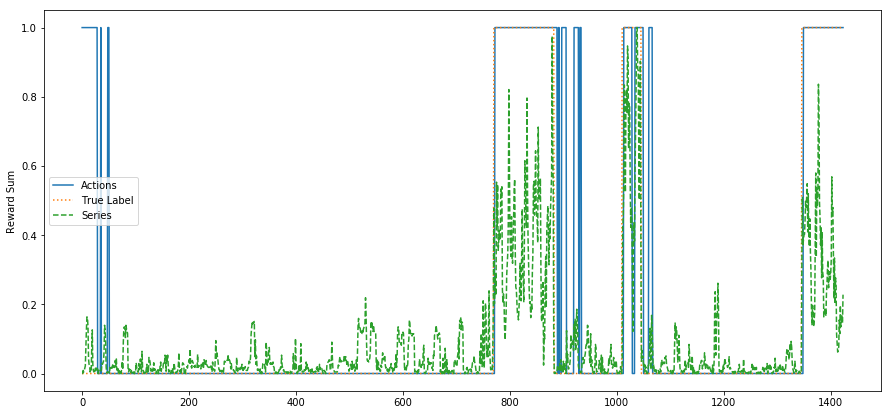

True

In [14]:
#tf.compat.v1.disable_eager_execution()

# Create the agent
config = ConfigTimeSeries(seperator=",", window=1)
env = WindowStateEnvironment(
    TimeSeriesEnvironment(verbose=True, filename="Test/SmallData_1.csv", config=config, window=True))

dqn = DDQNWAgent(env.action_space_n, 0.0001, 0.99, 1, 0.1, 0.9)
dqn.memory.init_memory(env)
simulation = Simulator(51, dqn, env, 5)
simulation.run()